In [193]:
!pip install torch torchvision mrcfile scikit-learn matplotlib

In [194]:
import torch
import torch.nn as nn
from torchvision import models
import mrcfile
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os

In [195]:
# Load the pre-trained 3D-ResNet34 model
class ResNet3D(nn.Module):
    def __init__(self):
        super(ResNet3D, self).__init__()
        self.model = models.video.r3d_18(pretrained=False)
        self.model.fc = nn.Identity()  # Remove the final classification layer

    def forward(self, x):
        return self.model(x)

In [198]:
# Initialize the model
model = ResNet3D()

In [199]:
# Load the state_dict
checkpoint = torch.load('/kaggle/input/resnet-34-kinetics-cpu-pth/resnet-34-kinetics-cpu.pth', map_location=torch.device('cpu'))
state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint

In [200]:
# Filter out unnecessary keys
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('model.'):
        new_state_dict[k[6:]] = v  # Remove 'model.' prefix

In [202]:
# Load the filtered state_dict
model.load_state_dict(new_state_dict, strict=False)
model.eval()

ResNet3D(
  (model): VideoResNet(
    (stem): BasicStem(
      (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
      (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (conv2): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (relu): ReLU(inplace=True)
      )
      (1): BasicBlock(
        (conv1): Sequential(
          (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3)

In [203]:
# Step 4: Read and Process cryo-ET Data for Multiple Samples
sample_dir = '/kaggle/input/cryo-et-samples/cryo-ET-samples'
cryo_data_list = []
filenames = []  # Initialize the filenames list 

In [205]:
for filename in os.listdir(sample_dir):
    if filename.endswith('.mrc'):
        with mrcfile.open(os.path.join(sample_dir, filename)) as mrc:
            cryo_data = mrc.data
            cryo_data = torch.tensor(cryo_data, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: [1, 1, D, H, W]
            cryo_data = cryo_data.repeat(1, 3, 1, 1, 1)  # Shape: [1, 3, D, H, W]
            cryo_data_list.append(cryo_data)
            filenames.append(filename)  # Save filenames for annotation

In [206]:
# Concatenate all cryo_data into a single tensor
cryo_data_all = torch.cat(cryo_data_list, dim=0)

In [207]:
# Step 5: Extract Features for All Samples
with torch.no_grad():
    features = model(cryo_data_all).numpy()

In [226]:
#Normalize the data:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features)
features_2d = tsne.fit_transform(features_normalized)

In [279]:
# Step 6: Dimensionality Reduction
# Adjusting perplexity parameter based on the sample size
perplexity = min(30, len(features) - 1)
#tsne = TSNE(n_components=2, random_state=0, perplexity=perplexity)
tsne = TSNE(n_components=2, random_state=0, perplexity=min(30, len(features) - 1), n_iter=5000)
features_2d = tsne.fit_transform(features)

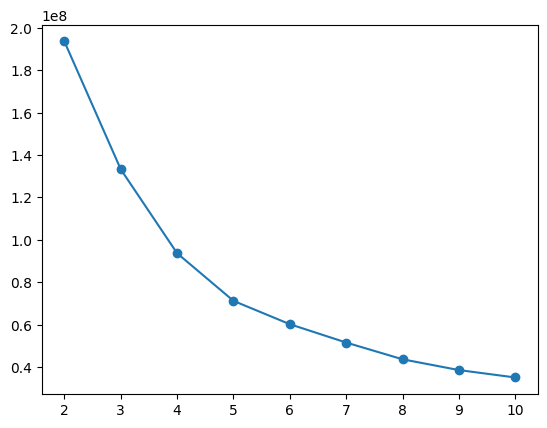

In [280]:
# Checking with the Inertia Method
cluster_numbers = [2, 3, 4, 5, 6, 7, 8, 9, 10]
inertia = []

for k in cluster_numbers:
    kmeans = KMeans(n_clusters=k, random_state=40, n_init=10).fit(features_2d)
    inertia.append(kmeans.inertia_)

#print(inertia)
plt.plot(cluster_numbers, inertia, marker='o')
plt.show()


In [273]:
# Step 7: Clustering with explicit n_init
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10)
clusters = kmeans.fit_predict(features_2d)

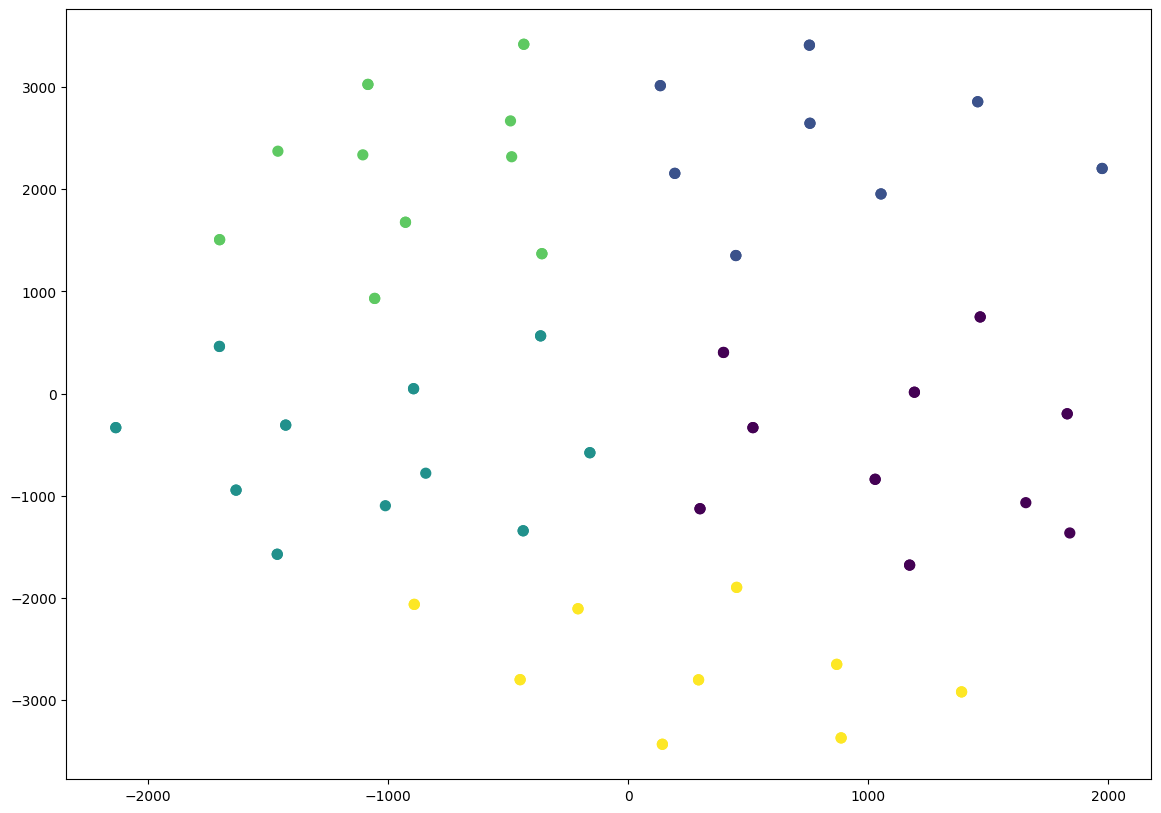

In [281]:
# Step 8: Visualization
plt.figure(figsize=(14, 10))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=clusters, cmap='viridis', s=50)